# Überprüfung des Objekttrackings

Die Ergebnisse des Objekttrackings sind derzeit leider nicht plausibel. Deshalb ist eine Überprüfung nötig. Dafür brauchen wir zunächst ein paar Pakete und müssen ein paar Pfade einbinden.

In [1]:
%matplotlib inline
import pandas as pd
import xarray as xr

import numpy as np
import pandas as pd
import xarray as xr

import sys
sys.path.append("/vols/talos/home/stephan/utils/tracking_neu")
import tracking_common as tc
import object_tracking as obt

import glob

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

from skimage import filters
from scipy import ndimage as ndi

/vols/talos/local/anaconda2-5.0.0/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
trackverzeichnis = "/vols/talos/home/stephan/data/radar_track/analyse_tracks/"
trackdatenverzeichnis = "/vols/talos/home/stephan/data/radar_track/trackdata/unkorrigiert"

Dann laden wir ein Beispiel.

In [3]:
track_id = "20130722_75"
track = pd.read_csv("{}/track_{}.csv".format(trackverzeichnis,track_id))
trackdata = xr.open_dataset("{}/haci_trackdata_{}.nc".format(trackdatenverzeichnis,track_id))

Für das Tracking müssen wir zunächst Objekte definieren. Wir benutzen ein Hystereseschwellwertverfahren. Dafür müssen wir Schwellwerte finden. Wir versuchen das zunächst mit dem mittleren Zeitschritt des Tracks.

In [4]:
def colorbar(mappable):
    ax = mappable.axes
    fig = ax.figure
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    return fig.colorbar(mappable, cax=cax)

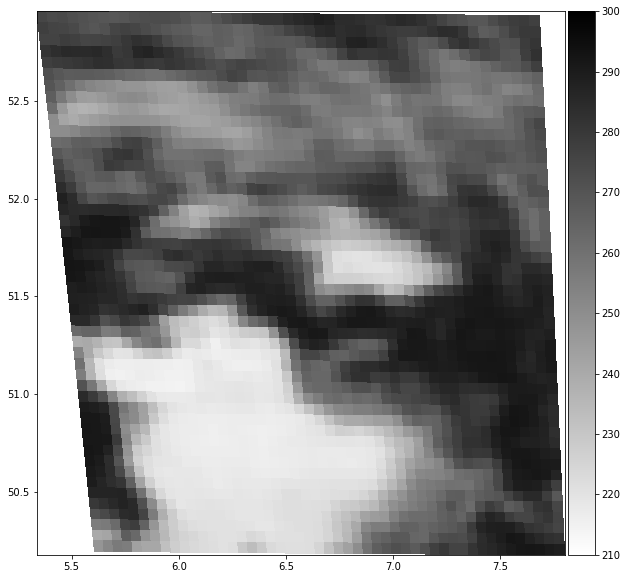

In [5]:
fig,ax = plt.subplots(1,1,figsize=(10,10))
ir_plot = ax.pcolormesh(trackdata.lon,trackdata.lat,trackdata.ir108.data[6],vmin=210,vmax=300,cmap='gray_r')
colorbar(ir_plot)

Wir haben in diesem Ausschnitt zwei Objekte, die wie konvektive Wolken aussehen. Es geht uns aber nur um das kleinere.

Dann sehen wir uns zunächst einmal das Histogramm der Szene an.

(array([  19.,  197., 1279., 1031.,  963.,  818.,  616.,  304.,  237.,
         241.,  222.,  207.,  204.,  173.,  207.,  166.,  229.,  277.,
         282.,  343.,  407.,  398.,  421.,  398.,  407.,  517.,  529.,
         612.,  690.,  687.,  781.,  925.,  874., 1073., 1003.,  996.,
        1041.,  909.,  945.,  930., 1007., 1044., 1120.,  997., 1154.,
        1140., 1324., 1285.,  748.,  123.]),
 array([212.3308  , 213.979426, 215.628052, 217.276678, 218.925304,
        220.57393 , 222.222556, 223.871182, 225.519808, 227.168434,
        228.81706 , 230.465686, 232.114312, 233.762938, 235.411564,
        237.06019 , 238.708816, 240.357442, 242.006068, 243.654694,
        245.30332 , 246.951946, 248.600572, 250.249198, 251.897824,
        253.54645 , 255.195076, 256.843702, 258.492328, 260.140954,
        261.78958 , 263.438206, 265.086832, 266.735458, 268.384084,
        270.03271 , 271.681336, 273.329962, 274.978588, 276.627214,
        278.27584 , 279.924466, 281.573092, 283.221718, 

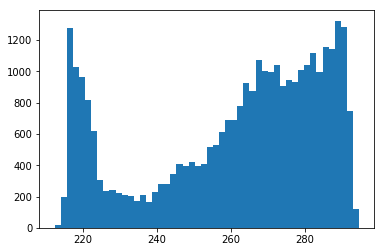

In [6]:
plt.hist(trackdata.ir108.data.ravel(),bins=50)

Die meisten Pixel liegen im Bereich über 260 K und ein größerer Teil auch über 240 K, aber es gibt einen zweiten Berg bei ca. 220 K. Das sind die Wolken, die uns interessieren.

Um die Wolken vom Hintergrund abzutrennen benutzen wir den Schwellwertansatz nach Yen (1995).

In [29]:
#background_threshold = filters.threshold_otsu(trackdata.ir108.data)
background_threshold = filters.threshold_yen(trackdata.ir108.data)
print background_threshold

262.07937753906253


Dann brauchen wir einen zweiten Schwellwert für die Kernbereiche der konvektiven Wolken.

In [31]:
core_threshold = np.percentile(trackdata.ir108.data,5)
print core_threshold

217.5396


Das ist schon eine ziemlich niedrige Temperatur (-55,61°C). Aber vielleicht funktioniert es.

In [34]:
objects, object_graphs = obt.track_object(trackdata.ir108.data,track_point='extreme')

In [35]:
print objects

[array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 4, ..., 0, 0, 0],
       [4, 4, 4, ..., 0, 0, 0]], dtype=int32), array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 3, ..., 0, 0, 0],
       [0, 3, 3, ..., 0, 0, 0]], dtype=int32), array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 4, 4, ..., 0, 0, 0]], dtype=int32), array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 3, 3, ..., 0, 0, 0]], dtype=int32), array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [5, 0, 0

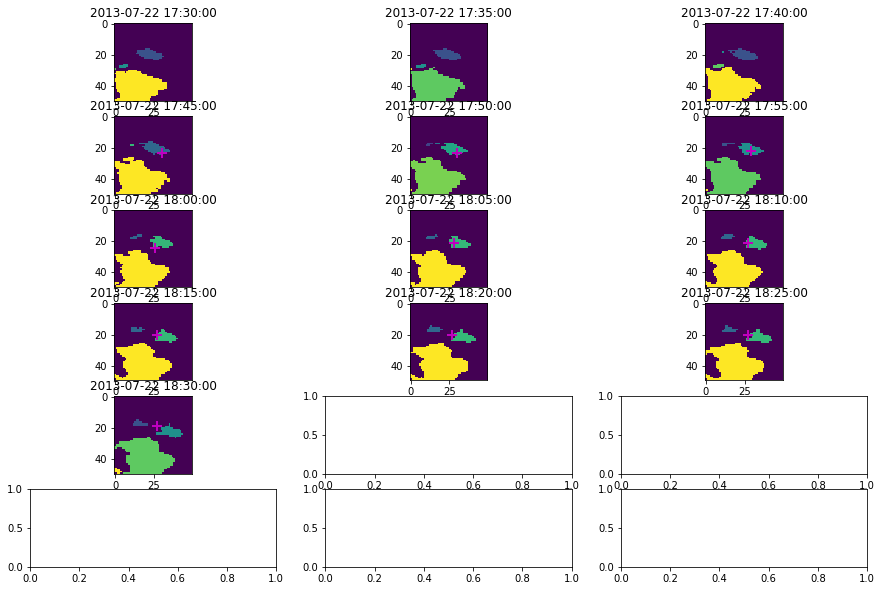

In [36]:
fig,ax = plt.subplots(6,3,figsize=(15,10))
axs = ax.ravel()

for i, obj in enumerate(objects):
    axs[i].imshow(obj)
    axs[i].plot(track.col_man[i],track.row_man[i],'m+',markersize=10,mew=2)
    axs[i].set_title(track.time[i])